# `xaitk-saliency` Increment 1 Demo <a name="Increment-1-Demo"></a>


## Set Up Environment <a name="Set-Up-Environment"></a>

In [ ]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q mlflow==1.30.0

## Downloading the Overhead-MNIST Dataset <a name="Download-the-Dataset-OverheadMNIST"></a>

The Overhead-MNIST dataset ([link](https://github.com/reveondivad/ov-mnist/raw/main/overhead.zip)) consists of 9584 28x28 grayscale satellite images (8519 - train images, 1065 - test images) over 10 different classes. Each image is stored as a column vector, resulting in a (9584,784) shape for the entire dataset.

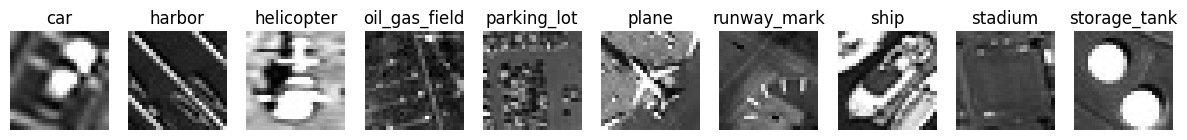

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import urllib
from zipfile import ZipFile

# Create data folder
data_path = "./data"
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Download and extract the dataset
file_path = os.path.join(data_path,"overhead.zip")
if not os.path.isfile(file_path):
    url = "https://github.com/reveondivad/ov-mnist/raw/main/overhead.zip"
    _ = urllib.request.urlretrieve(url, file_path)
    
with ZipFile(file_path,'r') as zfile:
    zfile.extractall(path=data_path)

# Load train data
train_split = pd.read_csv("./data/overhead/train.csv")
X_train,Y_train = train_split.iloc[:,1:].to_numpy(), train_split.iloc[:,0].to_numpy()
X_train = X_train/X_train.max()

# Find examples of each class
ref_inds = []
for i in range(10):
    ref_inds.append(np.where(np.int64(Y_train) == i)[0][0])
    
ref_imgs = X_train[ref_inds]
ref_labels = Y_train[ref_inds]

labels = pd.read_csv("./data/overhead/classes.csv")
label_names, label_idxs = labels["class"], labels["label"]

label_names_list = label_names.tolist()
label_idxs_list = label_idxs.to_list()

# Plot examples
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.title(f"{label_names_list[int(ref_labels[i])]}")
    plt.imshow(ref_imgs[i].reshape(28, 28), 'gray')
    plt.axis('off')

# MLP Classifier <a name="MLP-Classifier"></a>
## Fitting the Model <a name="Fitting-the-Model"></a>

We train a scikit-learn `MLPClassifier` on the Overhead-MNIST dataset.

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from pprint import pprint
from pathlib import Path

params = {"hidden_layer_sizes" : (112,), "max_iter" : 200, "alpha": 1e-4,
          "solver" :'adam', "verbose": False, "random_state": 1,
          "learning_rate_init" : .001}

mlp = MLPClassifier(**params)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")
    x = mlp.fit(X_train, Y_train)

# Load test data    
test_split = pd.read_csv("./data/overhead/test.csv")

X_test,Y_test = test_split.iloc[:,1:].to_numpy(), test_split.iloc[:,0].to_numpy()
X_test = X_test/X_test.max()

## Black-Box Classifier <a name="Black-Box-Classifier"></a>

We wrap our `MLPClassifier` object in [SMQTK-Classifier's](https://smqtk-classifier.readthedocs.io/en/stable/classifier_interfaces.html#classifyimage) `ClassifyImage` class to comply with the API's interface.

In [3]:
from smqtk_classifier.interfaces.classify_image import ClassifyImage

class OverheadMNISTClassifierMLP (ClassifyImage):
    def get_labels(self):
        return label_idxs_list
    
    def classify_images(self, image_iter):
        # Yes, "images" in this example case are really 1-dim (28*28=784).
        # MLP input needs a (n_samples, n_features) matrix input.
        images = np.asarray(list(image_iter))  # may fail because input is not consistent in shape
        images = images.reshape(-1, 28*28)  # may fail because input was not the correct shape
        return (
            {idx: p_i for idx, p_i in zip(range(10), p)}
            for p in mlp.predict_proba(images)
        )
    
    # Required for implementation
    def get_config(self):
        return {}
    
image_classifier_mlp = OverheadMNISTClassifierMLP()

## Initialize Saliency Algorithm <a name="Initialize-Saliency-Algorithm"></a>

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBlackboxSaliency` interface, to carry out our image perturbation and heatmap generation.

In [4]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingWindow = SlidingWindowStack(
    window_size=(2, 2),
    stride=(1, 1),
    threads=4
)

## Generating Saliency maps for a specific image <a name="Generate-Saliency"></a>

Generate class-wise saliency maps based on the specified `image_id`.

In [5]:
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency
import matplotlib.pyplot as plt

class GenerateSaliency():

    def gen_saliency_maps(self,
        image_id: int,
        img: np.ndarray,
        image_classifier: ClassifyImage,
        saliency_generator: GenerateImageClassifierBlackboxSaliency
    ):  

        # Generate saliency maps
        ref_image = img.reshape(28, 28)
        sal_maps = saliency_generator(ref_image, image_classifier)
        
        num_classes = sal_maps.shape[0]
        
        # Plot nth image in set with saliency maps
        fig1 = plt.figure(figsize=(10,5))
        plt.suptitle(f"Saliency Maps for Image_ID: {str(image_id)}", fontsize=16)
        num_cols = np.ceil(num_classes/2).astype(int) + 1
        plt.subplot(2, num_cols, 1)
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.xlabel(f"GT: {label_names_list[int(Y_test[image_id])]}, \nPred: {label_names_list[int(x.predict(np.expand_dims(X_test[image_id],axis=0)))]}")
        plt.xticks(())
        plt.yticks(())
        
        for c in range(num_cols - 1):
            plt.subplot(2, num_cols, c + 2)
            plt.imshow(sal_maps[c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"{label_names_list[c]}")
        for c in range(num_classes - num_cols + 1, num_classes):
            plt.subplot(2, num_cols, c + 3)
            plt.imshow(sal_maps[c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"{label_names_list[c]}")
        
        return fig1, sal_maps

# MLFlow: Run-based Workflow <a name="MLFlow"></a>

We implement an end-to-end pipeline example using MLFlow's `Experiment` and `Run` capabilities. Each experiment represents each stage of the pipeline as follows:
- &lt;Algorithm name&gt; - `Train`
- &lt;Algorithm name&gt; - `Evaluation`
- &lt;Algorithm name&gt; - `Saliency Map Generation`

We are using the MLP example here and so we set the &lt;Algorithm name&gt; to `MLPClassifier`.

Under each experiment, the information logging happens in the form of MLFlow runs. Finally, each run opens up a dashboard with 4 main information subsections:
- `Parameters` - Specifically used in the `Train` stage to store model parameters.
- `Metrics` - Different metrics are stored across different stages and are used, most importantly, in querying specific runs based on a given threshold value.
- `Tags` - Key-value pair entries containing information that is useful for querying and also to link runs across different stages of the pipeline.
- `Artifacts` - Used for storing saliency map images, numpy arrays, model metadata, etc.

## Instructions before running the MLFlow pipeline <a name="MLFlowInstructions"></a>
Before running the cells below, make sure to open a terminal, (activate your python venv if you are using one) and run the following commands:

> `cd "/working/directory/of/current/notebook"`
>
> `mlflow ui`

or execute the cell below to run as a python subprocess

In [ ]:
import subprocess
p = subprocess.Popen(["mlflow", "ui"])

## MLFlowXAI - Initialize MLFlow experiment <a name="MLFlowXAI"></a>

The `MLFlowXAI` class initalizes the variables and methods required for creating a new MLFlow experiment or retrieving an existing experiment with the same name.

In [6]:
import mlflow  # type: ignore
from mlflow import MlflowClient  # type: ignore
from mlflow.entities import ViewType # type: ignore
import random
from urllib.parse import urlparse

class MLFlowXAI():

    def __init__(self):
        self.mlruns_path = "./mlruns"
        self.framework = "sklearn"
        self.version = "v1"
        self.dataset = "OverheadMNIST"
        self.datasplit = "test"
        self.client = None
    
    def init_experiment(self,experiment_name):

        self.client = MlflowClient()
        client = self.client

        if not os.path.exists(self.mlruns_path):
            os.makedirs(os.path.join(self.mlruns_path,".trash"))
        
        current_experiment = client.get_experiment_by_name(experiment_name)
        
        if current_experiment == None:
            current_experiment_id = client.create_experiment(experiment_name,
                                            tags={"framework": self.framework, "version": self.version})
            client.set_experiment_tag(current_experiment_id, "Experiment", experiment_name)
            experiment_id = current_experiment_id
        else:
            experiment_id = current_experiment.experiment_id
        
        experiment = client.get_experiment(experiment_id)
        print("Name: {}".format(experiment.name))
        print("Experiment_id: {}".format(experiment.experiment_id))
        print("Artifact Location: {}".format(experiment.artifact_location))
        print("Tags: {}".format(experiment.tags))
        print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
        
        return experiment

MLFlowXAIobj = MLFlowXAI()

## MLFlowLogTraining - Create a run to log training info <a name="MLFlowLogTraining"></a>

The `MLFlowLogTraining` class implements the `log_training` method that creates a single MLFlow run that logs the model, parameters, metrics and tags from the `MLPClassifier` training.

In [7]:
class MLFlowLogTraining(MLFlowXAI):

    def __init__(self):
        
        super(MLFlowLogTraining,self).__init__()
    
    def log_training(self, experiment_name):
        
        experiment = self.init_experiment(experiment_name=experiment_name)
        
        with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="train_info") as run:

            # Assign train experiment and run IDs to class variables
            train_exp_id = experiment.experiment_id
            train_run_id = run.info.run_id

            # Model parameters
            mlflow.log_params(params)
            
            # Training loss for the MLP Classifier model (x)
            for epoch in x.loss_curve_:
                mlflow.log_metric('Train loss',epoch)

            # Set experiment tags
            mlflow.set_tags(experiment.tags)
            mlflow.set_tags({"Dataset": self.dataset})
            
            # Final model checkpoint
            mlflow.sklearn.log_model(x, artifact_path="sklearn-model")
        
        return train_exp_id, train_run_id

# Log training metrics for the trained sklearn MLP Classifier
MLFlowLogtrainingObj = MLFlowLogTraining()
train_exp_id, train_run_id = MLFlowLogtrainingObj.log_training("MLPClassifier - Train")

Name: MLPClassifier - Train
Experiment_id: 1
Artifact Location: file:///data/barry.ravichandran/XAITK/JATIC/xaitk-jatic/demos/mlruns/1
Tags: {'version': 'v1', 'framework': 'sklearn', 'Experiment': 'MLPClassifier - Train'}
Lifecycle_stage: active


/data/barry.ravichandran/envs/mlflow37/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## MLFlowLogEvaluation - Create "k" runs to log evaluation scores from "k" images <a name="MLFlowLogEvaluation"></a>

The `MLFlowLogEvaluation` class implements the `log_conf_score` method that starts "k" different MLFlow runs, where each run generates and logs the `Predicted_class_conf` and class-wise confidence scores as metrics and the GT and Predicted class labels as tags for the k<sup>th</sup> image. 

In [8]:
class MLFlowLogEvaluation(MLFlowXAI):

    def __init__(self):
        
        super(MLFlowLogEvaluation,self).__init__()

    def log_conf_score(self, experiment_name, train_exp_id, train_run_id):
        
        experiment = self.init_experiment(experiment_name=experiment_name)

        eval_exp_id = experiment.experiment_id
        
        img_count = 0

        # x is the trained MLP Classifier model
        pred_conf = x.predict_proba(np.concatenate((X_test[0:100],X_test[np.array([538,604,950,1041])])))
        
        image_ids = np.concatenate((np.arange(0,100),np.array([538,604,950,1041])))
        
        mean_accuracy = x.score(X_test, Y_test)

        for i in range(pred_conf.shape[0]):
            with mlflow.start_run(experiment_id=experiment.experiment_id,run_name="ImageID-" + str(image_ids[img_count]) + "_conf") as run:
                
                mlflow.set_tags(experiment.tags)
                
                class_conf = []
                for j in range(pred_conf.shape[1]):
                    conf = round(pred_conf[img_count,j],2)
                    class_conf.append(conf)
                
                max_conf = max(class_conf)
                max_conf_class = class_conf.index(max_conf)
                
                mlflow.log_metric('Mean_accuracy', mean_accuracy)
                mlflow.log_metric('Predicted_class_conf', max_conf)

                for classes in range(len(class_conf)):
                    mlflow.log_metric("Class_" + str(classes) + "_conf", class_conf[classes])
            
                mlflow.set_tags({"Image_id": str(image_ids[img_count]),
                                "Predicted_class": label_names_list[int(max_conf_class)],
                                "GT_class": label_names_list[int(Y_test[image_ids[img_count]])],
                                "Dataset": self.dataset,
                                "Datasplit": self.datasplit,
                                "Train_exp_id": train_exp_id, 
                                "Train_run_id": train_run_id})
            
            img_count += 1
        
        return eval_exp_id

# Log image confidence scores (currently using random values for conf scores)
MLFlowLogEvaluationObj = MLFlowLogEvaluation()
eval_exp_id = MLFlowLogEvaluationObj.log_conf_score("MLPClassifier - Evaluation", train_exp_id, train_run_id)

Name: MLPClassifier - Evaluation
Experiment_id: 2
Artifact Location: file:///data/barry.ravichandran/XAITK/JATIC/xaitk-jatic/demos/mlruns/2
Tags: {'version': 'v1', 'framework': 'sklearn', 'Experiment': 'MLPClassifier - Evaluation'}
Lifecycle_stage: active


## MLFlowQueryAndLogSaliency - Query a specific run from the Evaluation Stage and generate saliency maps <a name="MLFlowQueryAndLogSaliency"></a>

The `MLFlowQueryAndLogSaliency` class implements the `query_eval_run`, `log_saliency_maps` and `get_saliency_run_id` methods.

- `query_run` - Query runs from a particular MLFlow Experiment as a pandas dataframe based on an input filter string and order clause.

- `log_saliency_maps` - Single MLFlow run to generate (using `gen_saliency_maps` from `GenerateSaliency` class) saliency maps for a given image. This method can also be used to edit existing runs to add/modify information.

- `get_saliency_run_id` - Get the MLFlow run ID of an existing `log_saliency_maps` run.

Name: MLPClassifier - Saliency Map Generation
Experiment_id: 3
Artifact Location: file:///data/barry.ravichandran/XAITK/JATIC/xaitk-jatic/demos/mlruns/3
Tags: {'version': 'v1', 'framework': 'sklearn', 'Experiment': 'MLPClassifier - Saliency Map Generation'}
Lifecycle_stage: active


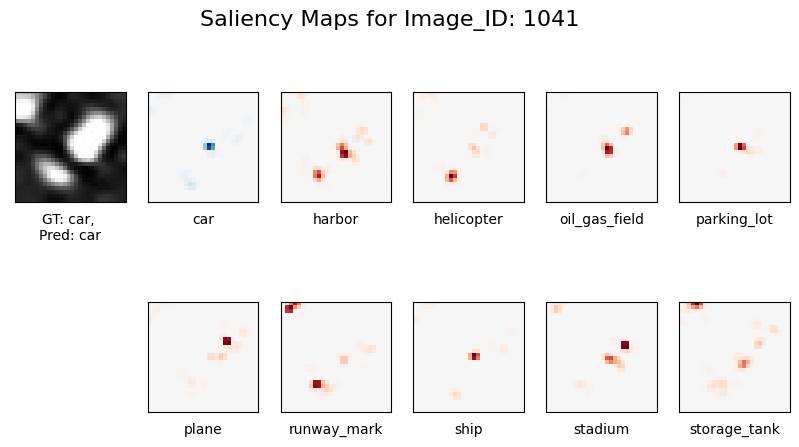

In [9]:
class MLFlowQueryAndLogSaliency(MLFlowXAI):

    def __init__(self):
        
        super(MLFlowQueryAndLogSaliency,self).__init__()
        self.saliency_run_id = None
        self.saliency_params= {}
        
    def query_run(self,filter_string,order_by,exp_id):
        
        run = mlflow.search_runs(
            experiment_ids=exp_id,
            filter_string=filter_string,
            run_view_type=ViewType.ACTIVE_ONLY,
            order_by=order_by
        )
        return run
    
    def set_saliency_params(self,saliency_params):
        self.saliency_params = saliency_params
        
    def get_saliency_params(self):
        return self.saliency_params
    
    def log_saliency_maps(self, experiment_name, conf_score, image_id, eval_exp_id, eval_run_id, sal_run_id):

        experiment = self.init_experiment(experiment_name=experiment_name)

        sal_exp_id = experiment.experiment_id
        
        with mlflow.start_run(experiment_id=sal_exp_id,run_name=f"ImageID-{image_id}_saliency_maps",run_id=sal_run_id if sal_run_id != None else None) as run:
            
            # Adding new tag to modified run
            if sal_run_id != None:
                modified_run = {"Modified_run": "True"}
                mlflow.set_tags(modified_run)
                mlflow.set_tag("mlflow.runName", f"ImageID-{image_id}_saliency_maps")
                
            self.saliency_run_id = run.info.run_id
        
            mlflow.set_tags(experiment.tags)
            mlflow.set_tags({"Dataset": self.dataset,
                            "Datasplit": self.datasplit,
                            "Evaluation_exp_id": eval_exp_id,
                            "Evaluation_run_id": eval_run_id})
            
            p = urlparse(experiment.artifact_location)
            
            smap_path = './saliency_map_np_arrays'
            if not os.path.exists(smap_path):
                os.makedirs(smap_path)
                
            img_saliency, sal_maps = GenerateSaliency().gen_saliency_maps(image_id, X_test[image_id], image_classifier_mlp, gen_slidingWindow)
            
            mlflow.log_params(self.get_saliency_params())
            
            np.save(os.path.join(smap_path,'image_saliency_maps.npy'), sal_maps)
            mlflow.log_artifact(smap_path)

            # Saliency maps saved under artifacts
            mlflow.log_figure(img_saliency,'Image_saliency_maps.png')

            mlflow.log_metric("Predicted_class_conf",conf_score)

            # Adding new metric and figure to modified run
            if sal_run_id != None:
                mlflow.log_metric("Predicted_class_conf_new",conf_score)
                mlflow.log_figure(img_saliency,'Image_saliency_maps_new.png')
                
            return sal_exp_id
    
    def get_saliency_run_id(self):
        return self.saliency_run_id


# Filter and query based on top_class_confidence_score metric and Top_conf_class tag

conf_threshold = 0.9
top_class = 'car'
filter_string = f"metrics.Predicted_class_conf >= " + str(conf_threshold) +" and tags.Predicted_class = '" + str(top_class) + "'"

order = "DESC" # or "ASC"
order_by = ["metrics.Predicted_class_conf " + order]

MLFlowQueryAndLogSaliencyObj = MLFlowQueryAndLogSaliency()
queried_runs = MLFlowQueryAndLogSaliencyObj.query_run(filter_string = filter_string, 
                                                    order_by = order_by, 
                                                    exp_id = eval_exp_id)

# Generate and log saliency maps for the top queried image id from the Evaluation stage.

top_confScore = queried_runs["metrics.Predicted_class_conf"][0]
top_confScore_imgID = int(queried_runs["tags.Image_id"][0])
top_confScore_runID = str(queried_runs["run_id"][0])

saliency_params = gen_slidingWindow.get_config()

MLFlowQueryAndLogSaliencyObj.set_saliency_params(saliency_params)

sal_exp_id = MLFlowQueryAndLogSaliencyObj.log_saliency_maps("MLPClassifier - Saliency Map Generation",
                                            top_confScore,
                                            top_confScore_imgID,
                                            eval_exp_id,
                                            top_confScore_runID,
                                            None)

## Reproduce Saliency Map results by querying existing run <a name="ReproduceSaliencyMaps"></a>

Using the ``saliency_run_id`` of an existing Saliency Generation run, we can query the Saliency Algorithm parameters and reproduce the same results as part of a new MLFlow run.

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Predicted_class_conf,params.threads,params.window_size,params.stride,...,tags.Datasplit,tags.mlflow.runName,tags.Experiment,tags.mlflow.source.name,tags.Dataset,tags.mlflow.user,tags.Evaluation_run_id,tags.framework,tags.mlflow.source.type,tags.version
0,899ae2ccf991497b9255f157dfd26489,3,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:23.224000+00:00,2023-06-26 16:36:23.933000+00:00,1.0,4,"[2, 2]","[1, 1]",...,test,ImageID-1041_saliency_maps,MLPClassifier - Saliency Map Generation,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,94f9ed50d18d4e5aa8990a92fd4cea8b,sklearn,LOCAL,v1


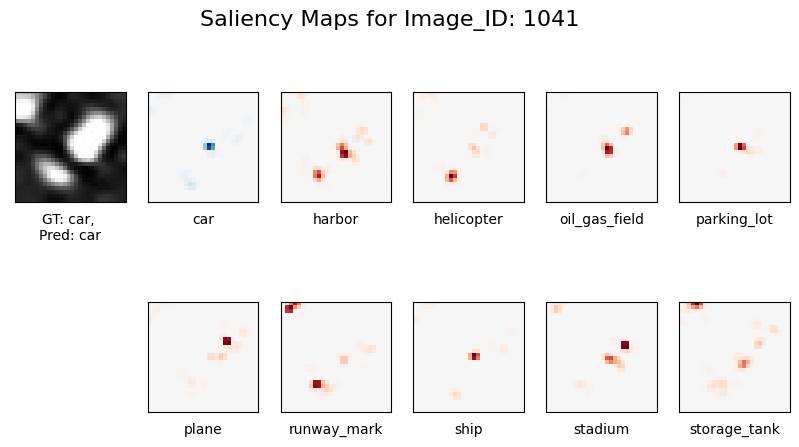

In [10]:
from IPython.display import display as ipython_display

filter_string = f"tags.Evaluation_run_id = '" + top_confScore_runID + "'"
order = "DESC" # or "ASC"
order_by = ["attribute.start_time " + order]

saliency_run_id = MLFlowQueryAndLogSaliencyObj.get_saliency_run_id()

# Querying Saliency parameters from an existing saliency generation run
queried_runs_saliency = MLFlowQueryAndLogSaliencyObj.query_run(filter_string = filter_string, 
                                                    order_by = order_by,
                                                    exp_id = sal_exp_id)
ipython_display(queried_runs_saliency)

window_size = tuple(eval(queried_runs_saliency["params.window_size"][0]))
stride = tuple(eval(queried_runs_saliency["params.stride"][0]))
threads = int(queried_runs_saliency["params.threads"][0])

gen_slidingWindow_rep_test = SlidingWindowStack(
    window_size=window_size,
    stride=stride,
    threads=threads
)

img_saliency, sal_maps = GenerateSaliency().gen_saliency_maps(top_confScore_imgID, X_test[top_confScore_imgID], image_classifier_mlp, gen_slidingWindow_rep_test)

## Edit existing Saliency Generation run <a name="MLFlowEditSaliency"></a>

We use the `get_saliency_run_id` method to return the MLFlow Run ID of an existing saliency generation run. Instead of creating a new run like the example cell above, we edit an existing run to generate and update the saliency maps for the queried ``Image_ID``.

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Class_0_conf,metrics.Mean_accuracy,metrics.Class_1_conf,metrics.Predicted_class_conf,...,tags.Experiment,tags.Predicted_class,tags.mlflow.source.name,tags.Dataset,tags.mlflow.user,tags.Train_exp_id,tags.GT_class,tags.framework,tags.mlflow.source.type,tags.version
0,44b0e530aeef4fc0861bd6131c681e5a,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.896000+00:00,2023-06-26 16:36:20.914000+00:00,0.0,0.63662,0.0,1.00,...,MLPClassifier - Evaluation,oil_gas_field,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,oil_gas_field,sklearn,LOCAL,v1
1,45243224dd684c9a9b692cdc9b83bd29,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.303000+00:00,2023-06-26 16:36:20.321000+00:00,0.0,0.63662,0.0,1.00,...,MLPClassifier - Evaluation,oil_gas_field,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,oil_gas_field,sklearn,LOCAL,v1
2,2bbaf89bbdad4840bddd45ad367e30f8,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.596000+00:00,2023-06-26 16:36:20.613000+00:00,0.0,0.63662,0.0,0.99,...,MLPClassifier - Evaluation,oil_gas_field,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,oil_gas_field,sklearn,LOCAL,v1
3,912198863df54d31bfb7b9411b5a0082,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:19.977000+00:00,2023-06-26 16:36:19.998000+00:00,0.0,0.63662,0.0,0.98,...,MLPClassifier - Evaluation,oil_gas_field,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,parking_lot,sklearn,LOCAL,v1
4,d5dc2ccfa1414311a6676107d688453c,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:19.021000+00:00,2023-06-26 16:36:19.040000+00:00,0.0,0.63662,0.0,0.98,...,MLPClassifier - Evaluation,oil_gas_field,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,oil_gas_field,sklearn,LOCAL,v1


Name: MLPClassifier - Saliency Map Generation
Experiment_id: 3
Artifact Location: file:///data/barry.ravichandran/XAITK/JATIC/xaitk-jatic/demos/mlruns/3
Tags: {'version': 'v1', 'framework': 'sklearn', 'Experiment': 'MLPClassifier - Saliency Map Generation'}
Lifecycle_stage: active


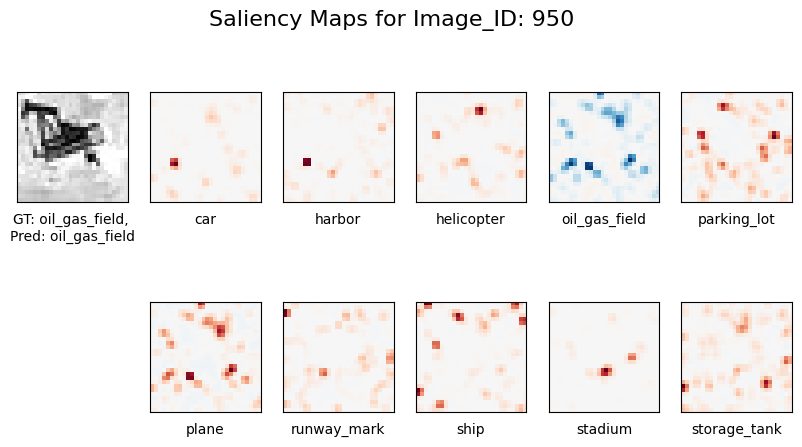

In [11]:
# Get Run ID of existing saliency generation run (in this case the most recent run)
existing_sal_run_id = MLFlowQueryAndLogSaliencyObj.get_saliency_run_id()

conf_threshold = 0.9
top_class = 'oil_gas_field'
filter_string = f"metrics.Predicted_class_conf >= " + str(conf_threshold) +" and tags.Predicted_class = '" + str(top_class) + "'"

order = "DESC" # or "ASC"
order_by = ["metrics.Predicted_class_conf " + order]

queried_runs_new = MLFlowQueryAndLogSaliencyObj.query_run(filter_string = filter_string, 
                                                    order_by = order_by, 
                                                    exp_id = eval_exp_id)

ipython_display(queried_runs_new)

top_confScore_new = queried_runs_new["metrics.Predicted_class_conf"][0]
top_confScore_imgID_new = int(queried_runs_new["tags.Image_id"][0])
top_confScore_runID_new = str(queried_runs_new["run_id"][0])

# Updated the existing run's tags, parameters and artifacts based on the new queried image
sal_exp_id = MLFlowQueryAndLogSaliencyObj.log_saliency_maps("MLPClassifier - Saliency Map Generation",
                                            top_confScore_new,
                                            top_confScore_imgID_new,
                                            eval_exp_id,
                                            top_confScore_runID_new,
                                            existing_sal_run_id)

## Additional Saliency Examples <a name="Additional-Saliency-Examples"></a>



### GT - Car, Prediction - Car (Low confidence score)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Class_0_conf,metrics.Mean_accuracy,metrics.Class_1_conf,metrics.Predicted_class_conf,...,tags.Experiment,tags.Predicted_class,tags.mlflow.source.name,tags.Dataset,tags.mlflow.user,tags.Train_exp_id,tags.GT_class,tags.framework,tags.mlflow.source.type,tags.version
0,ed66d90f3d2f43f3b9a2db7c55ee4d05,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.876000+00:00,2023-06-26 16:36:20.894000+00:00,0.63,0.63662,0.01,0.63,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
1,94f9ed50d18d4e5aa8990a92fd4cea8b,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.916000+00:00,2023-06-26 16:36:20.934000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
2,3a20e0ab81da4d1e9542ac8a0943064d,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.814000+00:00,2023-06-26 16:36:20.832000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
3,26b4c0f3adff4e3daea3d20f5b5f4f4d,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.382000+00:00,2023-06-26 16:36:20.399000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
4,e200a49117c94eb3b9189ab15ae612b5,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.113000+00:00,2023-06-26 16:36:20.130000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
5,bf6ee466b986408db641bf9d1562a3bc,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.020000+00:00,2023-06-26 16:36:20.037000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
6,b709c03fd69043e2bcda0e2e9a4f512a,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:19.862000+00:00,2023-06-26 16:36:19.882000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
7,4ddc389515ea4953942bcf8bcd91baaa,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:19.632000+00:00,2023-06-26 16:36:19.652000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
8,fb6979fa797d477ca680dfcf8f5fedc7,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:19.192000+00:00,2023-06-26 16:36:19.211000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1
9,37f01c0e8c2f4a669ac9d9abdd4b2ef0,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:19.042000+00:00,2023-06-26 16:36:19.061000+00:00,1.00,0.63662,0.00,1.00,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,car,sklearn,LOCAL,v1


Predicted class confidence = 0.63


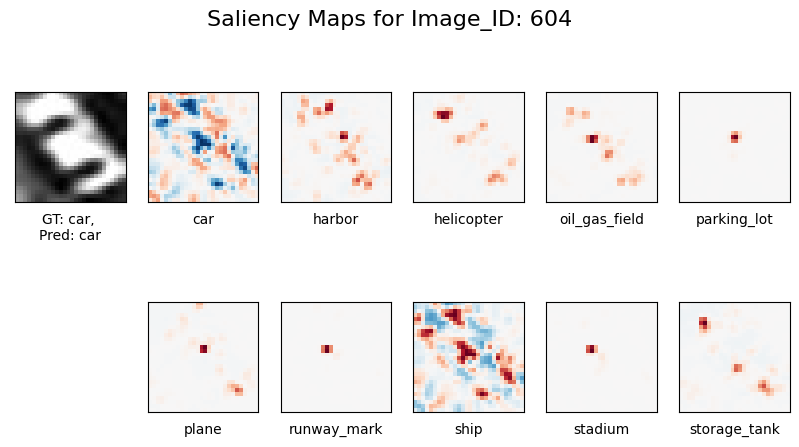

In [12]:
conf_threshold = 0.5
pred_class = 'car'
gt_class = 'car'
filter_string = f"metrics.Predicted_class_conf >= " + str(conf_threshold) +" and tags.Predicted_class = '" + str(pred_class) + "'" + " and tags.GT_class = '" + str(gt_class) + "'"

order = "ASC"
order_by = ["metrics.Predicted_class_conf " + order]

queried_runs = MLFlowQueryAndLogSaliencyObj.query_run(filter_string = filter_string, 
                                                    order_by = order_by,
                                                    exp_id = eval_exp_id)
ipython_display(queried_runs)

top_confScore = queried_runs["metrics.Predicted_class_conf"][0]
print("Predicted class confidence = " + str(top_confScore))
top_confScore_imgID = int(queried_runs["tags.Image_id"][0])
top_confScore_runID = str(queried_runs["run_id"][0])

img_saliency, sal_maps = GenerateSaliency().gen_saliency_maps(top_confScore_imgID, X_test[top_confScore_imgID], image_classifier_mlp, gen_slidingWindow)

### GT - Stadium, Prediction - Car

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Class_0_conf,metrics.Mean_accuracy,metrics.Class_1_conf,metrics.Predicted_class_conf,...,tags.Experiment,tags.Predicted_class,tags.mlflow.source.name,tags.Dataset,tags.mlflow.user,tags.Train_exp_id,tags.GT_class,tags.framework,tags.mlflow.source.type,tags.version
0,c03e8a41e1104056ad70df1bcfe06506,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:20.855000+00:00,2023-06-26 16:36:20.874000+00:00,0.84,0.63662,0.15,0.84,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,stadium,sklearn,LOCAL,v1
1,357c525e5d4d4a83a37a9818c0489005,2,FINISHED,file:///data/barry.ravichandran/XAITK/JATIC/xa...,2023-06-26 16:36:19.498000+00:00,2023-06-26 16:36:19.518000+00:00,0.75,0.63662,0.25,0.75,...,MLPClassifier - Evaluation,car,/data/barry.ravichandran/envs/mlflow37/lib/pyt...,OverheadMNIST,barry.ravichandran,1,stadium,sklearn,LOCAL,v1


Predicted class confidence = 0.84


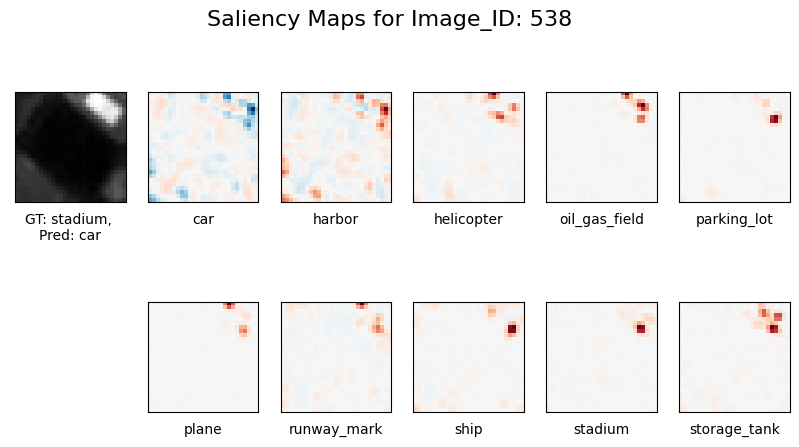

In [13]:
conf_threshold = 0.5
pred_class = 'car'
gt_class = 'stadium'
filter_string = f"metrics.Predicted_class_conf >= " + str(conf_threshold) +" and tags.Predicted_class = '" + str(pred_class) + "'" + " and tags.GT_class = '" + str(gt_class) + "'"

order = "DESC"
order_by = ["metrics.Predicted_class_conf " + order]

queried_runs = MLFlowQueryAndLogSaliencyObj.query_run(filter_string = filter_string, 
                                                    order_by = order_by,
                                                    exp_id = eval_exp_id)
ipython_display(queried_runs)

top_confScore = queried_runs["metrics.Predicted_class_conf"][0]
print("Predicted class confidence = " + str(top_confScore))
top_confScore_imgID = int(queried_runs["tags.Image_id"][0])
top_confScore_runID = str(queried_runs["run_id"][0])

img_saliency, sal_maps = GenerateSaliency().gen_saliency_maps(top_confScore_imgID, X_test[top_confScore_imgID], image_classifier_mlp, gen_slidingWindow)

## Permanently delete existing MLFlow experiment <a name="MLFlowDeleteExperiment"></a>

While interacting with the MLFlow UI, the process of deleting an existing experiment does not permanently delete the contents of the experiment from the backend store. So, after deleting an experiment using the UI, it is important to run the following command from a terminal for permanent deletion:

> `mlflow gc`

## Key Takeaways <a name="Key-Takeaways"></a>
- MLflow provides functionality that can facilitate reproducible model test and evaluation (T&E) workflows.
    - Experiment tracking, artifact storage, model serving, and dashboard visualizations.
- Using a run-based workflow enables easy compartmentalization of different pipelines for model training, evaluation, and use of T&E tools (e.g. ``xaitk-saliency``).
- Querying MLflow for dataset examples and computing saliency maps on these examples can be used as part of T&E engineer's workflow to identify model failure modes and edge cases.

## Undemonstrated Increment 1 Work <a name="Undemonstrated-Increment-1-Work"></a>

- Gradio integration for side-by-side model comparison of predictions and saliency maps.
- Integration of ``xaitk-saliency`` with ``armory`` for combining adversarial attacks with saliency maps.
- Integration of ``xaitk-saliency`` with JATIC toolbox augmentation protocol for studying impact of perturbations on saliency maps.
- Preliminary exploration of ["Shared Interest"](http://shared-interest.csail.mit.edu/) approach of using saliency-based metrics to filter dataset examples.